# Procesamiento de imágenes · Tarea 6

En esta tarea aplicaremos lo aprendido sobre procesamiento morfológico, incluyendo dilatación, erosión y _region growing_.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.

## Configuración inicial

##### Importamos librerías

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

##### Aumentamos el tamaño de las imágenes

In [2]:
plt.rcParams['figure.dpi'] = 200

## Parte 1 · _Region growing_ para una imagen binaria

Comencemos con una pequeña imagen binaria de un corazón.

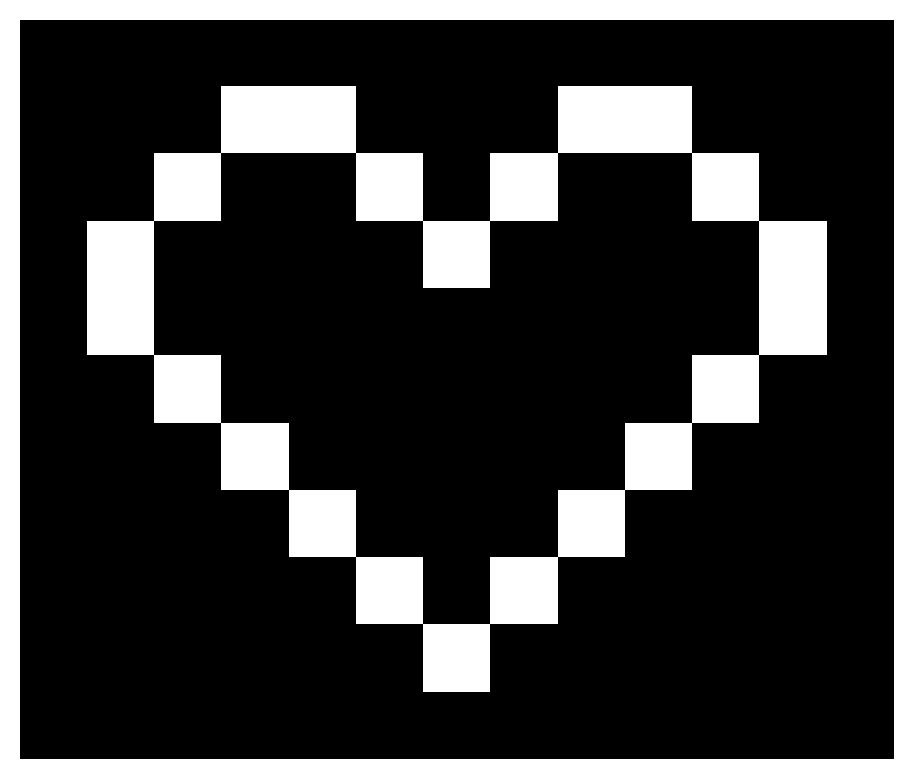

In [3]:
img_pixel = np.zeros((11, 13), dtype=np.uint8)

coords = ((1,3), (1,4), (1, 8), (1, 9), (2, 2), (2, 5),
            (2, 7), (2, 10), (3, 1), (3, 6), (3, 11), (4, 1),
            (4, 11), (5, 2), (5, 10), (6, 3), (6, 9), (7, 4),
            (7, 8), (8, 5), (8, 7), (9, 6))

img_pixel[tuple(zip(*coords))] = 1

plt.imshow(img_pixel, cmap='gray')
plt.axis('off');

En clases vimos un algoritmo de _region growing_ que dilata un pixel semilla para ir rellenando el área dentro de un perímetro.

Implementa este algoritmo en la función ```region_growing_morphology```, recibiendo una imagen binaria (como ```img_pixel```) y las coordenadas del pixel semilla como una tupla ```(y, x)```. Debe retornar una imagen donde los pixeles dentro del perímetro valgan uno y el resto cero. El perímetro debe valer cero. Como no llegaremos a los bordes de la imagen, no te preocupes por esos casos extremos.

In [4]:
def region_growing_morphology(img, coordinates):
    y = coordinates[0]
    x = coordinates[1]
    img[y,x] = 1
    # Pixel below
    if img[y-1,x] == 0:
        img[y-1,x] = 1
        region_growing_morphology(img,(y-1,x))

    # Pixel above
    if img[y+1,x] == 0:
        img[y+1,x] = 1
        region_growing_morphology(img,(y+1,x))

    # Pixel at left side
    if img[y,x-1] == 0:
        img[y,x-1] = 1
        region_growing_morphology(img,(y,x-1))

    # Pixel at right side
    if img[y,x+1] == 0:
        img[y,x+1] = 1
        region_growing_morphology(img,(y,x+1))

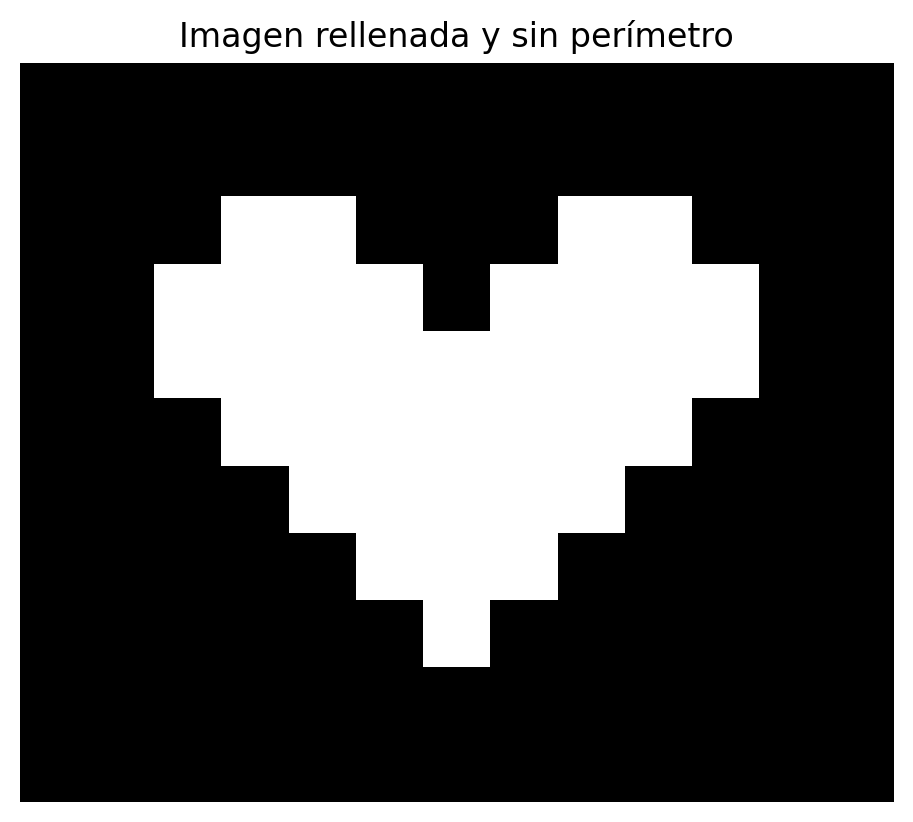

In [5]:
copy_img = img_pixel.copy()
region_growing_morphology(copy_img, (5, 5))

region_pixel = copy_img & (~img_pixel) 
plt.imshow(region_pixel, cmap='gray')
plt.title("Imagen rellenada y sin perímetro")
plt.axis('off');

## Parte 2 · Segmentación de imágenes a color

Tenemos una foto de una apetitosa ensalada de fruta y queremos extraer una frambuesa y una uva. Estas están señaladas en la imagen a color.

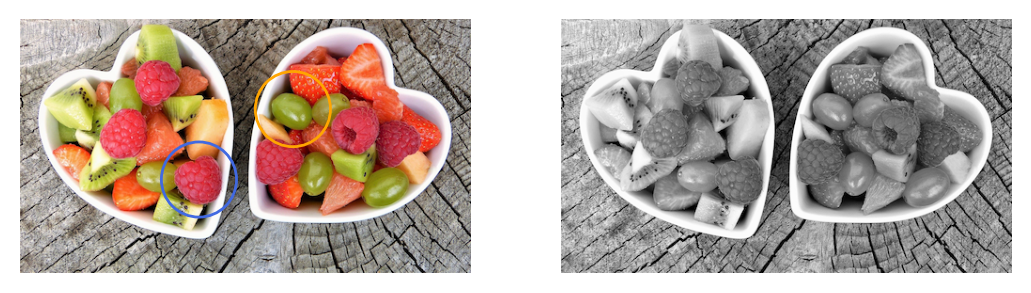

In [6]:
img_fruit_path = 'fruit.png'
img_fruit = cv2.imread(img_fruit_path, cv2.IMREAD_COLOR)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(cv2.cvtColor(img_fruit, cv2.COLOR_BGR2RGB))
circle = plt.Circle((190, 170), 40, color='royalblue', fill=False)
axs[0].add_patch(circle)
circle = plt.Circle((290, 95), 40, color='orange', fill=False)
axs[0].add_patch(circle)
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(img_fruit, cv2.COLOR_BGR2GRAY), cmap='gray')
axs[1].axis('off');

La imagen en escala de grises no pareciera ser favorable para segmentar las frutas. Veamos cómo se ve cada canal por separado.

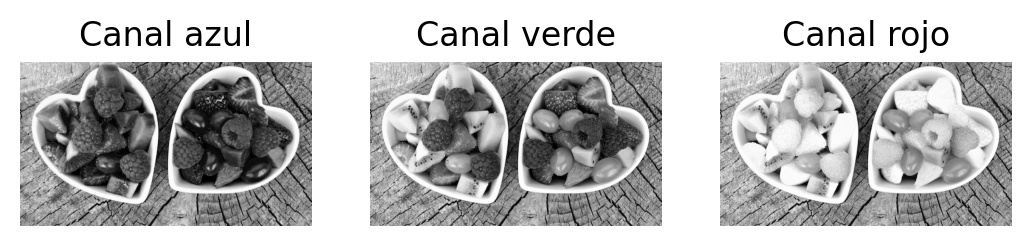

In [7]:
plt.subplot(1, 3, 1)
plt.imshow(img_fruit[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Canal azul')

plt.subplot(1, 3, 2)
plt.imshow(img_fruit[:, :, 1], cmap='gray')
plt.axis('off')
plt.title('Canal verde')

plt.subplot(1, 3, 3)
plt.imshow(img_fruit[:, :, 2], cmap='gray')
plt.axis('off')
plt.title('Canal rojo');

En el canal azul hay un bajo contraste entre las frutas. En el verde y rojo se ven mayores diferencias.

Podemos crear una nueva imagen a partir de la suma ponderada de los canales. A través de ensayo y error se encuentra una combinación que exhibe un gran contraste entre las distintas frutas. Es importante notar que los pixeles de la imagen ya no estarán entre 0 y 255.

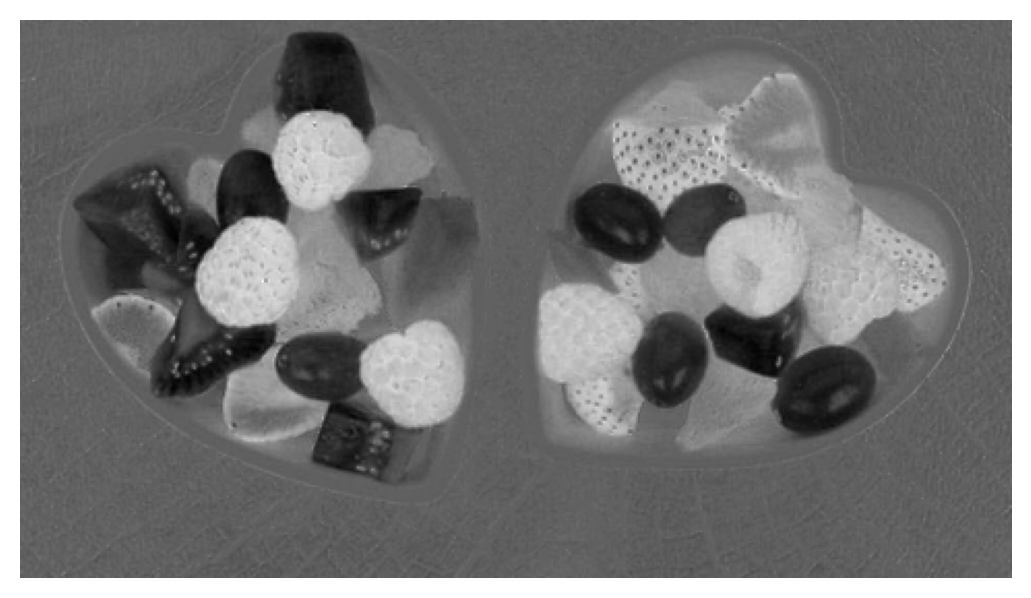

In [8]:
img_fruit_new = img_fruit.astype(np.int16)
img_fruit_new = (img_fruit_new[:, :, 0] + img_fruit_new[:, :, 2] - 2*img_fruit_new[:, :, 1])
plt.subplot(1, 1, 1)
plt.imshow(img_fruit_new, cmap='gray')
plt.axis('off');

Las dos frutas que queremos extraer tienen un tono de gris distinto al de sus alrededores, lo que nos facilitará el trabajo que sigue.

Veamos qué pasa cuando intentamos segmentar las frutas con umbrales globales.

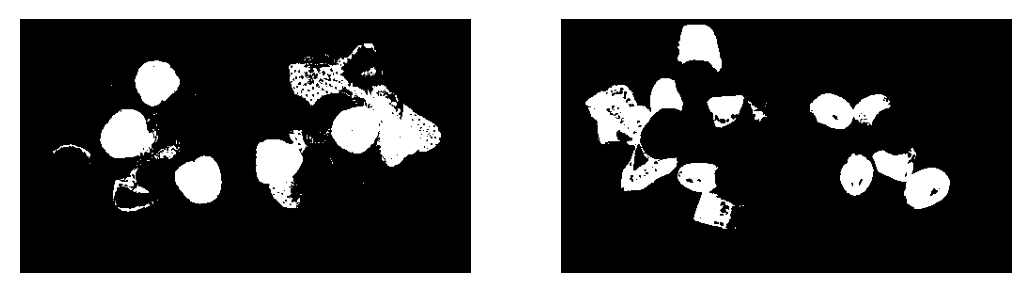

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(img_fruit_new > 100, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_fruit_new < -50, cmap='gray')
plt.axis('off');

Las frutas que queremos extraer se segmentan medianamente bien, pero obviamente no son lo único presente en la imagen. Necesitamos una estrategia distinta. Utilicemos un algoritmo de _region growing_ que nos permita obtener los pixeles conectados y con tono de gris similar a un pixel semilla.

Implementa el algoritmo de _region growing_ en la función ```region_growing_grayscale```. Esta debe recibir una imagen en escala de grises, las coordenadas de un pixel semilla ```(y, x)``` y un _threshold_. Debe hacer crecer el pixel semilla, agregando todo pixel _[4-connected](https://en.wikipedia.org/wiki/Pixel_connectivity#4-connected)_ cuyo valor se diferencie en menos de ```threshold``` al pixel semilla. Debe retornar una imagen donde los pixeles pertenecientes a la región valgan uno y el resto cero. Como no llegaremos a los bordes de la imagen, no te preocupes por esos casos extremos.

En [este](https://en.wikipedia.org/wiki/Flood_fill) artículo puedes encontrar el pseudo-código de algoritmos que podrían ayudarte.

In [10]:
# Escribe tu código en las siguientes líneas
def region_growing_grayscale(img_input, coordinates, threshold):
    img_output = np.zeros(img_input.shape, dtype=np.uint8)
    yo, xo = coordinates
    seed_value = img_input[yo,xo]
    
    def expand(y,x):
        # If we are out ot the limits, or if the pixel is already checked
        if (y < 0)or(x < 0)or(y >= img_input.shape[0])or(x >= img_input.shape[1])or(img_output[y,x] == 1):
            return
        # Else we are going to check it
        else:
            if abs(img_input[y,x] - seed_value) < threshold:
                img_output[y,x] = 1
                
                # Expand to analize above, below, right and left pixel
                expand(y+1, x)
                expand(y-1, x)
                expand(y, x+1)
                expand(y, x-1)
                
    expand(yo, xo)
    return img_output

Segmentemos la frambuesa con el algoritmo. El pixel semilla está en (170, 190) y usaremos un _threshold_ igual a 60.
Si el algoritmo funciona correctamente, deberías ver la forma de la frambuesa en blanco.

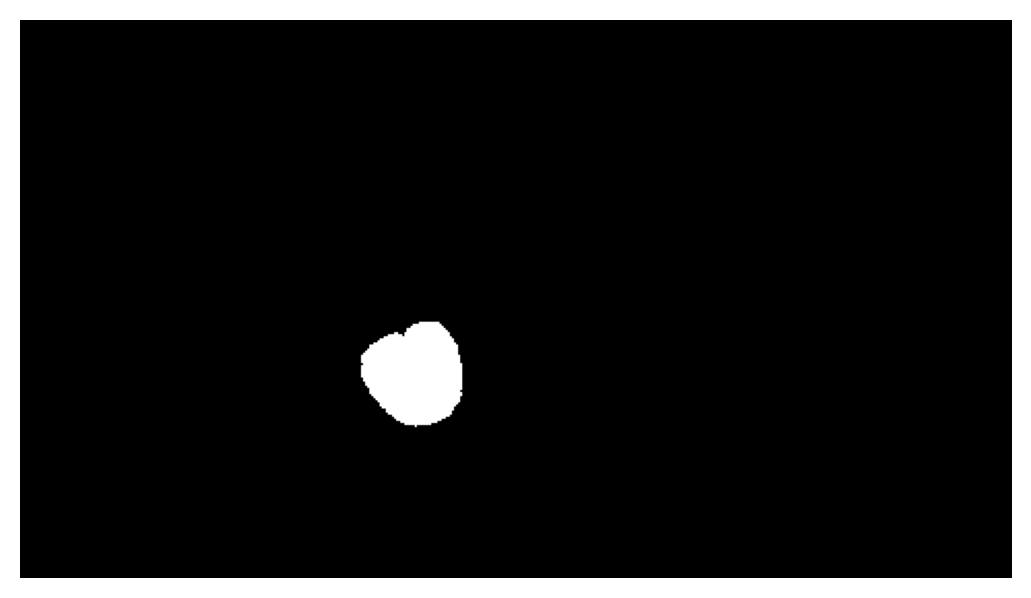

In [11]:
mask_raspberry = region_growing_grayscale(img_fruit_new, (170, 190), 60)

plt.imshow(mask_raspberry, cmap='gray')
plt.axis('off');

Repitamos lo mismo para la uva y veamos cómo nos va.

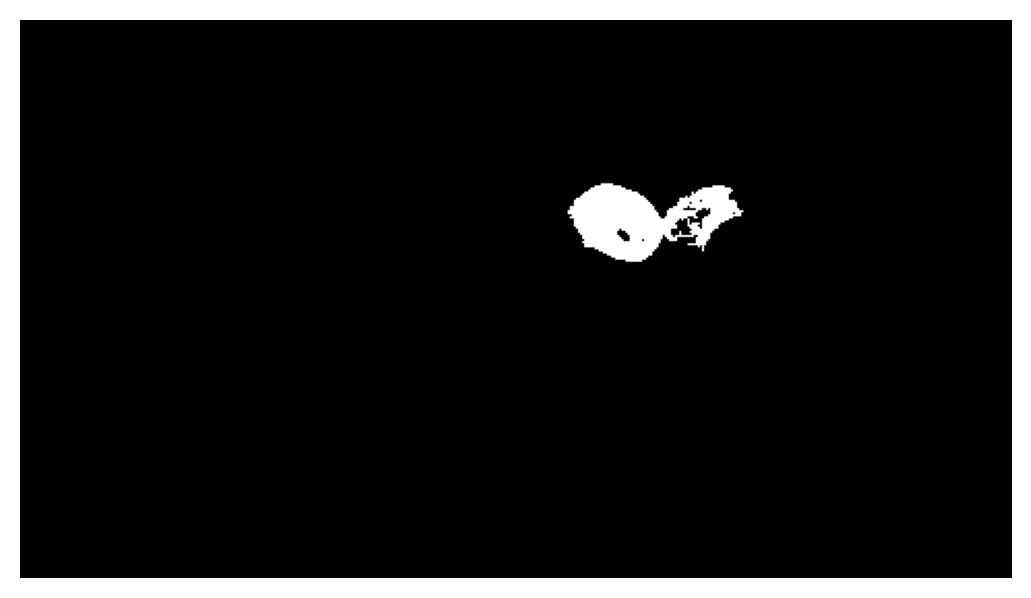

In [12]:
mask_grape = region_growing_grayscale(img_fruit_new, (100, 295), 60)

plt.imshow(mask_grape, cmap='gray')
plt.axis('off');

Como hay una uva de un color similar al lado de la que queremos segmentar, esta también fue incluida en la máscara. Bajemos el umbral a 30.

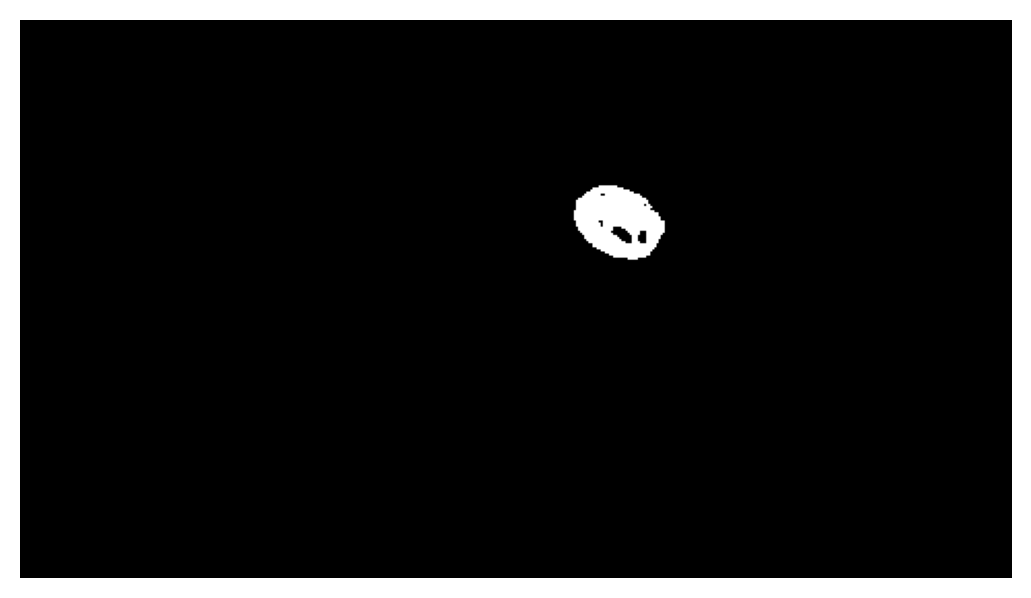

In [13]:
mask_grape = region_growing_grayscale(img_fruit_new, (100, 295), 30)

plt.imshow(mask_grape, cmap='gray')
plt.axis('off');

Logramos eliminar la segunda uva pero ahora faltó parte de la primera. Como vimos en clases, podemos rellenar agujeros realizando primero una dilatación y después una erosión.

Cierra los agujeros aplicando tres dilataciones y luego tres erosiones. Guarda el resultado en ```mask_grape_filled```. Usa las funciones de [aquí](https://docs.scipy.org/doc/scipy/reference/ndimage.html#morphology).

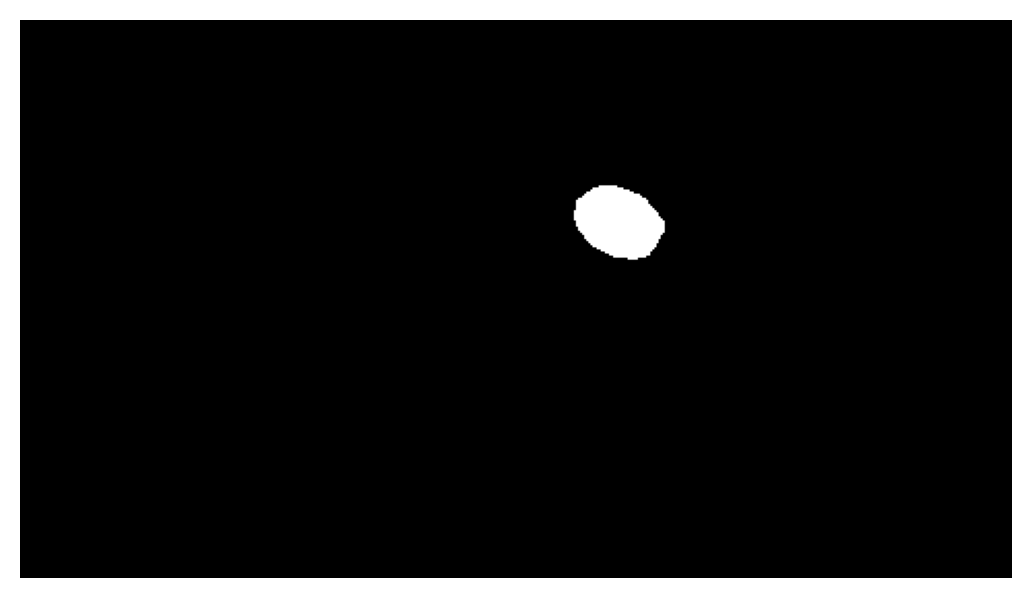

In [14]:
from scipy import ndimage
mask_grape_filled = ndimage.binary_dilation(mask_grape, iterations = 3)
mask_grape_filled = ndimage.binary_erosion(mask_grape_filled, iterations = 3)

# Transformamos a 0 y 1
mask_grape_filled = mask_grape_filled.astype(np.uint8)

plt.imshow(mask_grape_filled, cmap='gray')
plt.axis('off');

Finalmente, apliquemos las máscaras obtenidas a la imagen a color original para obtener una imagen que solo incluya las dos frutas a color. Ya hemos hecho esto en tareas pasadas. Guarda el resultado en ```img_fruit_masked```. Debe ser un arreglo tridimensional compuesto por ```uint8``` entre 0 y 255.

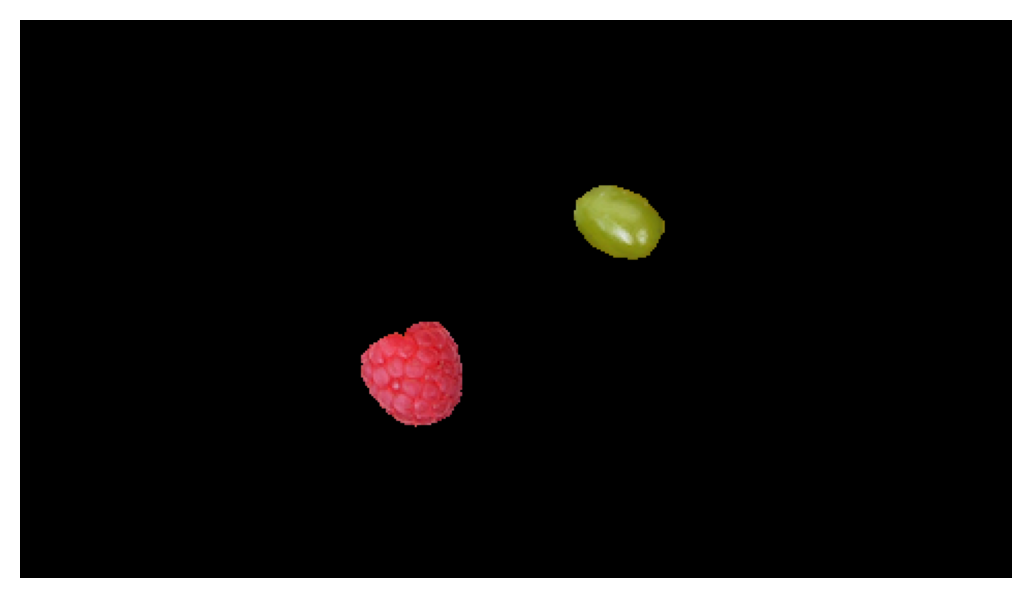

In [15]:
fruits_mask = (mask_grape_filled)|(mask_raspberry)
# Apply mask multiplying by the mask adding the other axis
img_fruit_masked = img_fruit * fruits_mask[:,:, np.newaxis]
# Cast data types to unsigned integers of 8 bits
img_fruit_masked = img_fruit_masked.astype(np.uint8)
plt.subplot(1, 1, 1)
plt.imshow(img_fruit_masked[:, :, ::-1])
plt.axis('off');

¡Fantástico! Aprendiste a rellenar el interior de un perímetro y lograste segmentar dos frutas usando operaciones morfológicas.